In [1]:
!pip install xlrd

In [1]:
import pandas as pd
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
#import geopandas as gpd
#from shapely.geometry import Point, LineString, Polygon
#import fiona
import statistics
import contextily as cx
from haversine import haversine, Unit
import haversine as hs
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import folium
import statsmodels.api as sm

In [2]:
xls = pd.ExcelFile('../data/6 vehicles/21mar24_10-54_6Trips.xls')

In [3]:
xls.sheet_names

['24.03 R1 10.54 PS',
 '24.03 R1 10.54 RW',
 '24.03 R1 10.54 JC',
 '24.03 R1 10.54 DW',
 '24.03 R1 10.54 AA',
 '24.03 R1 10.54 AK']

In [4]:
driver = ['PS', 'JC', 'RW', 'DW', 'AA', 'AK']
sheet = ['24.03 R1 10.54 PS',
 '24.03 R1 10.54 JC',
 '24.03 R1 10.54 RW',
 '24.03 R1 10.54 DW',
 '24.03 R1 10.54 AA',
 '24.03 R1 10.54 AK']

In [5]:
fogli = []
for i in range(len(sheet)):
    df = pd.read_excel('../data/6 vehicles/21mar24_10-54_6Trips__.xls', sheet_name=str(sheet[i]))
    df['driver'] = driver[i]
    fogli.append(df)

In [6]:
#pd.concat(fogli, axis=0).reset_index(drop=True).to_csv('/home/selihadji/Documenti/papers/COMPSAC2022/Hamburg/alldata.csv', index=False)

In [7]:
alldata = pd.concat(fogli, axis=0).reset_index(drop=True)
alldata.columns

Index(['Time[s]', 'Latitude', 'Longtitude', 'Speed[m/s]', 'Altitude[m]',
       'Flag', 'Acceleration[m/s^2]', 'AccWork[J]', 'AeroWork[J]',
       'GradeWork[J]', 'RollWork[J]', 'StandStillWork[J]', 'TotalWork[J]',
       'StandStillTime[s]', 'Fuel[l]', 'CO2[kg]', 'AccECE[%]', 'AeroECE[%]',
       'STSECE[%]', 'WorkECE[%]', 'x/[m]', 'v [km/h]', 'time_', 'Unnamed: 23',
       'driver', 'x[m]', 'v[km/h]', 'x', 'v'],
      dtype='object')

In [8]:
alldata.columns
alldata = alldata[['Time[s]','time_', 'Latitude', 'Longtitude', 'Speed[m/s]','Acceleration[m/s^2]','CO2[kg]','Fuel[l]','driver']]

In [9]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8105 entries, 0 to 8104
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Time[s]              8105 non-null   int64         
 1   time_                8105 non-null   datetime64[ns]
 2   Latitude             8105 non-null   float64       
 3   Longtitude           8105 non-null   float64       
 4   Speed[m/s]           8105 non-null   float64       
 5   Acceleration[m/s^2]  8103 non-null   float64       
 6   CO2[kg]              8103 non-null   float64       
 7   Fuel[l]              8103 non-null   float64       
 8   driver               8105 non-null   object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 570.0+ KB


In [10]:
#coord_ = [Point(x, y) for x, y in zip(alldata.Longtitude, alldata.Latitude)]
#alldata_ = gpd.GeoDataFrame(alldata, geometry=coord_, crs ="EPSG:4326")

In [11]:
drivers = ['PS', 'AK', 'JC', 'RW', 'DW', 'AA']

In [12]:
alldata_SORTED = alldata.sort_values(by = 'time_').reset_index(drop=True)

In [13]:
ps = alldata_SORTED[alldata_SORTED.driver == 'PS'].reset_index(drop=True).drop_duplicates()
ak = alldata_SORTED[alldata_SORTED.driver == 'AK'].reset_index(drop=True).drop_duplicates()
jc = alldata_SORTED[alldata_SORTED.driver == 'JC'].reset_index(drop=True).drop_duplicates()
rw = alldata_SORTED[alldata_SORTED.driver == 'RW'].reset_index(drop=True).drop_duplicates()
dw = alldata_SORTED[alldata_SORTED.driver == 'DW'].reset_index(drop=True).drop_duplicates()
aa = alldata_SORTED[alldata_SORTED.driver == 'AA'].reset_index(drop=True).drop_duplicates()

In [14]:
infr = pd.read_csv('infrast_data.csv', sep=';')
feat = infr['what'].unique()
infr = infr.reset_index()

infr = infr[~infr['index'].isin([0,11,14,16,17,18,20,21,44,47,64,65,71])].reset_index().drop(['level_0'],axis='columns')

infr['what'].value_counts()

Traffic_light          41
Curve                   7
Turn_left               6
Turn_right              6
4-ways intersection     3
Road_immission          1
Name: what, dtype: int64

In [15]:
infr.reset_index().drop(['level_0'],axis='columns')

,index,what,lat,lon
0,1,Traffic_light,53.550523,9.969615
1,2,Traffic_light,53.550082,9.969438
2,3,Traffic_light,53.546138,9.969437
3,4,Traffic_light,53.545436,9.972425
4,5,Traffic_light,53.545162,9.973444
...,...,...,...,...
59,72,Turn_right,53.552747,9.985368
60,73,Turn_right,53.557635,9.983789
61,74,Turn_right,53.557595,9.993096
62,75,Turn_right,53.557573,9.976766


In [16]:
df = ps
b_lat = df['Latitude'].mean() 
b_lon = df['Longtitude'].mean() 
m = folium.Map(location=[b_lat,b_lon], zoom_start=12, tiles="Stamen Terrain")

folium.PolyLine(df[['Latitude','Longtitude']],color='#000000',weight=5).add_to(m)


def draw_cars(time,color='red'):
    def f(row,color):
        i = folium.Icon(color=color, icon='fa-car',prefix='fa')
        folium.Marker(location=[row['Latitude'], row['Longtitude']],icon=i,popup=row['driver']).add_to(m)
    alldata_SORTED[alldata_SORTED['time_']==np.datetime64(time)].apply(f,axis='columns',args=[color])
    
        
draw_cars('2021-03-24 10:00:00','black')    
draw_cars('2021-03-24 10:03:00','red')    
draw_cars('2021-03-24 10:15:00','purple')    


icon_dict = {
'Traffic_light':('lightblue','fa-ellipsis-v','fa'),
'Turn_left':('blue','circle-arrow-left','glyphicon'),
'Curve':('blue','share-alt','glyphicon'),
'Turn_right':('blue','circle-arrow-right','glyphicon'),
'4-ways intersection':('blue','remove','glyphicon'),
'Road_immission':('blue','fa-code-fork','fa'),
}

def f(row):
    pop = f"{row['index']} {row['what']}"
    c,i,p = icon_dict[row['what']]
    i = folium.Icon(color=c, icon=i,prefix=p)
    folium.Marker(location=[row['lat'], row['lon']],icon=i,popup=pop).add_to(m)
     
infr.apply(f,axis='columns')


m

In [17]:
drivers = [ps,ak,jc,rw,dw,aa]
for df in drivers:
    df['CO2[kg]_CUM'] = df['CO2[kg]'].expanding().sum()

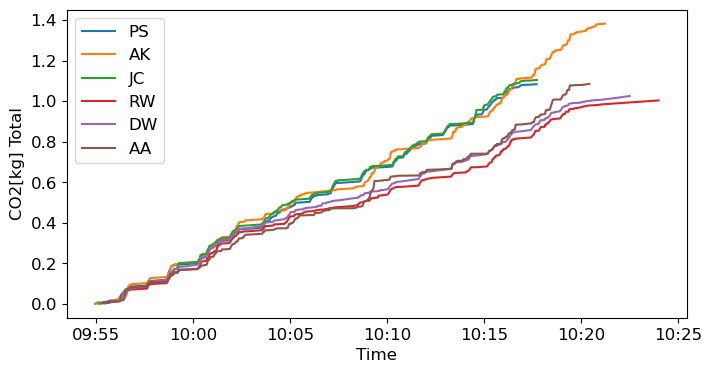

In [18]:
plt.figure(figsize = (8, 4))
plt.rcParams.update({'font.size': 12})
for df in drivers:
    plt.plot(df['time_'],df['CO2[kg]_CUM'],label=df.loc[0,'driver'])
plt.gcf().axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel('Time')
plt.ylabel('CO2[kg] Total')
plt.legend(loc='best')
plt.savefig('images/cum_co2.pdf',bbox_inches='tight')  
plt.show()

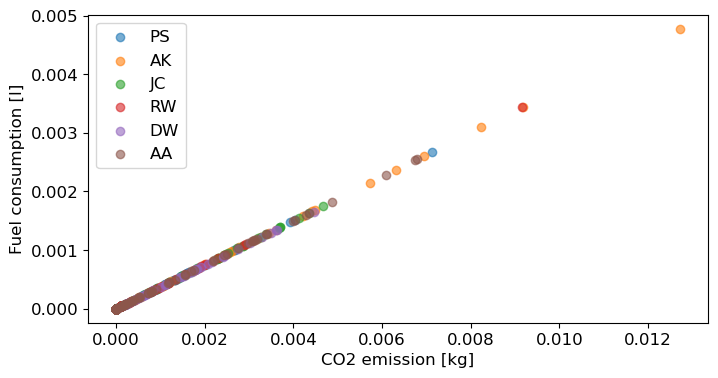

In [19]:
plt.figure(figsize = (8, 4))
plt.rcParams.update({'font.size': 12})
for df in drivers:
    sdf = df.sample(n=100)
    plt.scatter(sdf['CO2[kg]'],sdf['Fuel[l]'],label=sdf.iloc[0,-2],alpha=0.6)
plt.xlabel('CO2 emission [kg]')
plt.ylabel('Fuel consumption [l]')
plt.legend(loc='best')
plt.savefig('images/co2_fuel.pdf',bbox_inches='tight') 
plt.show()

In [20]:
sdf

,Time[s],time_,Latitude,Longtitude,Speed[m/s],Acceleration[m/s^2],CO2[kg],Fuel[l],driver,CO2[kg]_CUM
983,1616581192,2021-03-24 10:19:52,53.555336,9.974000,1.44,-0.110,0.000000,0.000000,AA,1.079477
753,1616580919,2021-03-24 10:15:19,53.560577,9.990927,9.25,0.570,0.002432,0.000913,AA,0.756676
262,1616580115,2021-03-24 10:01:55,53.544090,9.981136,4.26,2.800,0.003381,0.001269,AA,0.274129
198,1616580039,2021-03-24 10:00:39,53.545437,9.971624,3.83,-1.640,0.000000,0.000000,AA,0.191395
827,1616580993,2021-03-24 10:16:33,53.564156,9.980495,12.86,-0.100,0.000260,0.000097,AA,0.860877
...,...,...,...,...,...,...,...,...,...,...
160,1616579975,2021-03-24 09:59:35,53.546383,9.969844,1.66,0.270,0.000000,0.000000,AA,0.167867
268,1616580121,2021-03-24 10:02:01,53.544098,9.981817,9.19,0.460,0.001696,0.000637,AA,0.289373
875,1616581075,2021-03-24 10:17:55,53.562241,9.975939,12.24,0.290,0.000905,0.000340,AA,0.932173
581,1616580591,2021-03-24 10:09:51,53.557076,9.984148,5.02,0.360,0.000000,0.000000,AA,0.610288


In [21]:
def f(row,lat,lon):
    return hs.haversine((row['Latitude'],row['Longtitude']),(lat,lon),unit=Unit.METERS)

for i in range(infr.shape[0]):
    k = infr.loc[i,'what']
    for df in drivers:
        df[k] = False


for i in range(infr.shape[0]):
    k = infr.loc[i,'what']
    coord = (infr.loc[i,'lat'],infr.loc[i,'lon'])
    for df in drivers:
        df['tmp'] = df.apply(f,axis='columns',args=coord)
        if(min(df['tmp']) < 10):

            
            df[k] = np.where(df['tmp'] == min(df['tmp']), True, df[k])

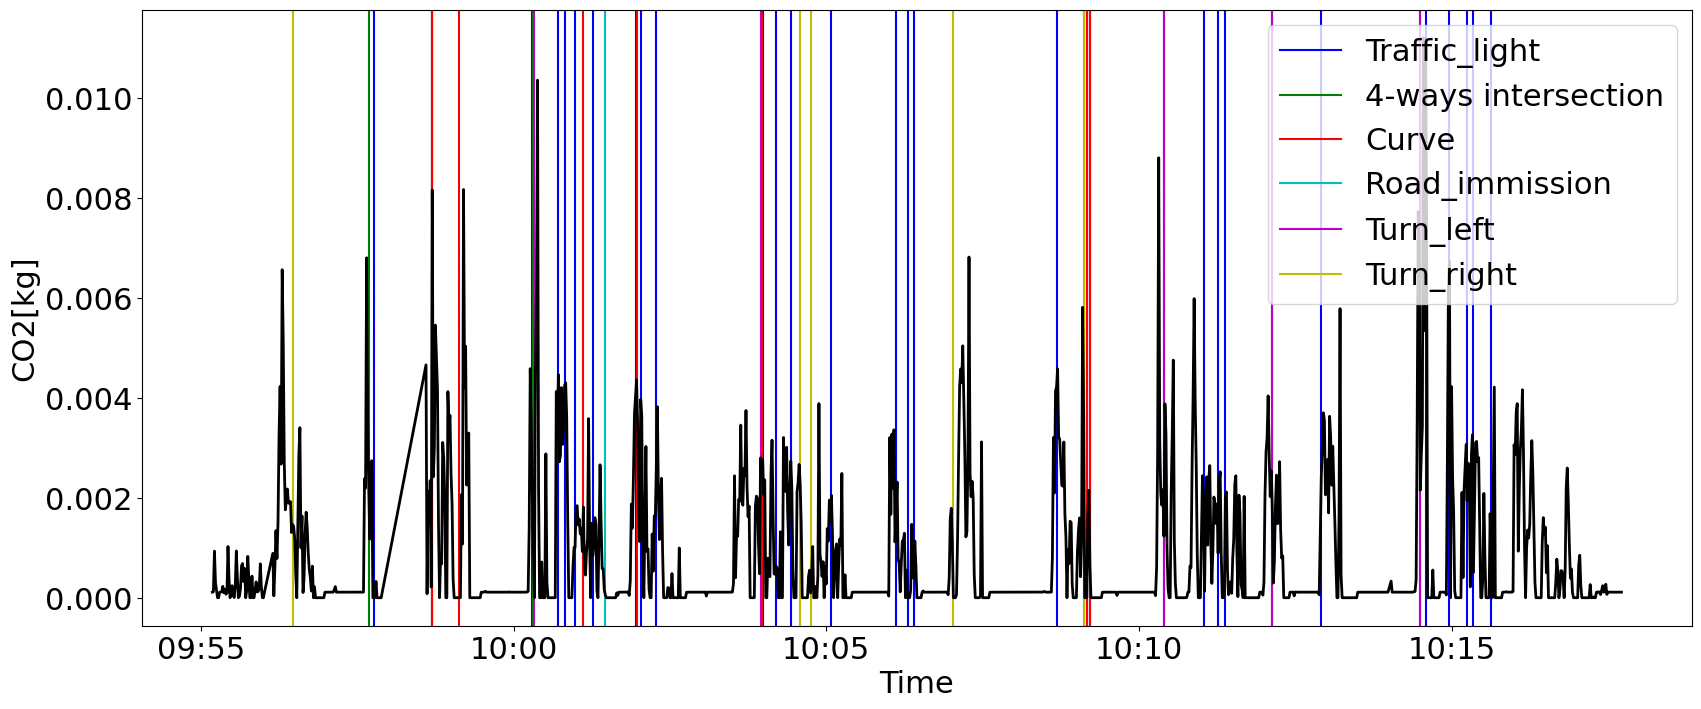

In [22]:
df = jc
plt.figure(figsize = (20, 8))
plt.rcParams.update({'font.size': 22})
# plot feat
for i in range(len(feat)):
    first = True
    f = feat[i]
    c = list(mcolors.BASE_COLORS.values())[i]
    for t in df[df[f]]['time_']:
        if first:
            plt.axvline(t,color=c,label=f)
            first = False
        else:
             plt.axvline(t,color=c)
            

plt.plot(df['time_'],df['CO2[kg]'],linewidth=2,c='#000000', )
plt.gcf().axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel('Time')
plt.ylabel('CO2[kg]')
plt.legend(loc='best')
plt.savefig('images/co2.pdf',bbox_inches='tight')  
plt.show()

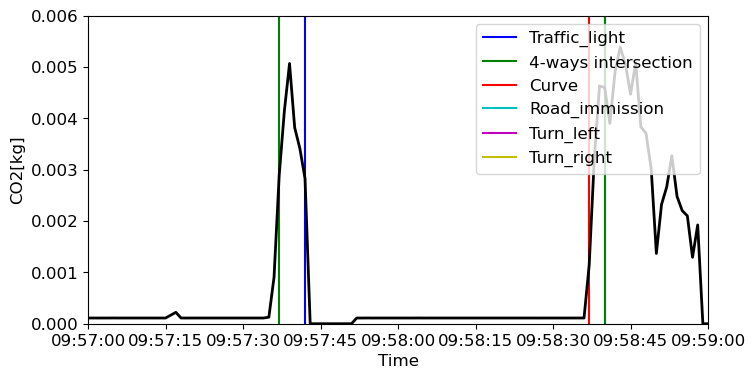

In [23]:
import datetime
df = ps
plt.figure(figsize = (8, 4))
plt.rcParams.update({'font.size': 12})
# plot feat
for i in range(len(feat)):
    first = True
    f = feat[i]
    c = list(mcolors.BASE_COLORS.values())[i]
    for t in df[df[f]]['time_']:
        if first:
            plt.axvline(t+datetime.timedelta(seconds=-3),color=c,label=f)
            first = False
        else:
             plt.axvline(t,color=c)
            

plt.plot(df['time_'],df['CO2[kg]'],linewidth=2,c='#000000', )
plt.gcf().axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xlabel('Time')
plt.ylabel('CO2[kg]')
plt.legend(loc='upper right')
# plt.xlim(np.datetime64('2021-03-24 10:08:00'),np.datetime64('2021-03-24 10:10:00'))
plt.xlim(np.datetime64('2021-03-24 09:57:00'),np.datetime64('2021-03-24 09:59:00'))
plt.ylim(0,0.006)
plt.savefig('images/co2-zoom.pdf',bbox_inches='tight')  
plt.show()

In [24]:
platoon_all = df
platoon_all

,Time[s],time_,Latitude,Longtitude,Speed[m/s],Acceleration[m/s^2],CO2[kg],Fuel[l],driver,CO2[kg]_CUM,Traffic_light,4-ways intersection,Curve,Road_immission,Turn_left,Turn_right,tmp
0,1616579696,2021-03-24 09:54:56,53.555782,9.972534,1.21,NaN,NaN,NaN,PS,NaN,False,False,False,False,False,False,217.309799
1,1616579698,2021-03-24 09:54:58,53.555778,9.972510,1.53,0.160,0.000347,0.000130,PS,0.000347,False,False,False,False,False,False,216.940923
2,1616579699,2021-03-24 09:54:59,53.555774,9.972457,2.56,1.030,0.000969,0.000364,PS,0.001316,False,False,False,False,False,False,216.608796
3,1616579700,2021-03-24 09:55:00,53.555761,9.972406,3.02,0.460,0.000676,0.000254,PS,0.001992,False,False,False,False,False,False,215.364591
4,1616579702,2021-03-24 09:55:02,53.555714,9.972346,3.71,0.345,0.001343,0.000504,PS,0.003335,False,False,False,False,False,False,210.532632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,1616581058,2021-03-24 10:17:38,53.555851,9.972632,0.02,0.010,0.000112,0.000042,PS,1.083586,False,False,False,False,False,False,224.941898
1306,1616581059,2021-03-24 10:17:39,53.555851,9.972632,0.01,-0.010,0.000111,0.000042,PS,1.083697,False,False,False,False,False,False,224.941898
1307,1616581060,2021-03-24 10:17:40,53.555851,9.972632,0.01,0.000,0.000111,0.000042,PS,1.083808,False,False,False,False,False,False,224.941898
1308,1616581061,2021-03-24 10:17:41,53.555851,9.972632,0.01,0.000,0.000111,0.000042,PS,1.083920,False,False,False,False,False,False,224.941898


In [25]:

def f(row):
    return hs.haversine((row['Latitude_x'],row['Longtitude_x']),(row['Latitude_y'],row['Longtitude_y']),unit=Unit.METERS)

df = [ps,jc,rw,dw,aa,ak]
names = ['PS','JC','RW','DW','AA','AK']

distances = {}

for i in range(len(df)):
    for j in range(i+1,len(df)):
        x = df[i][['time_','Latitude','Longtitude']].merge(df[j][['time_','Latitude','Longtitude']],on='time_')
        x['dist'] = x.apply(f,axis='columns')
        distances[names[i]+'-'+names[j]] = x

list(distances.keys())

['PS-JC',
 'PS-RW',
 'PS-DW',
 'PS-AA',
 'PS-AK',
 'JC-RW',
 'JC-DW',
 'JC-AA',
 'JC-AK',
 'RW-DW',
 'RW-AA',
 'RW-AK',
 'DW-AA',
 'DW-AK',
 'AA-AK']

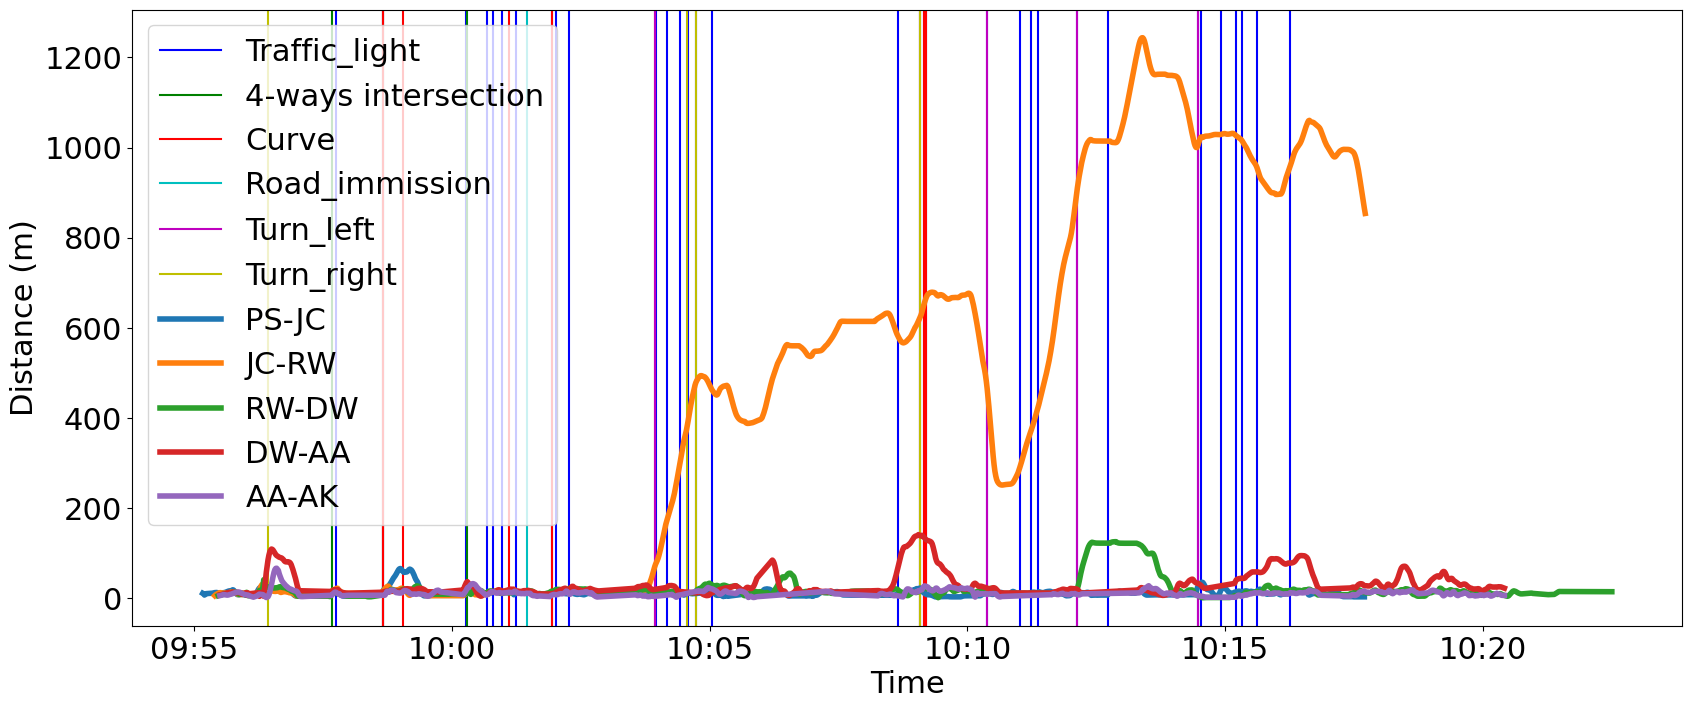

In [26]:
plt.figure(figsize = (20, 8))
plt.rcParams.update({'font.size': 22})
# plot feat
# plot feat
for i in range(len(feat)):
    first = True
    f = feat[i]
    c = list(mcolors.BASE_COLORS.values())[i]
    for t in platoon_all[platoon_all[f]]['time_']:
        if first:
            plt.axvline(t,color=c,label=f)
            first = False
        else:
             plt.axvline(t,color=c)

#keys = list(distances.keys())
keys = ['PS-JC','JC-RW','RW-DW','DW-AA','AA-AK']
                
for k in keys:
    plt.plot(distances[k]['time_'],distances[k]['dist'],label=k,linewidth=4)
plt.gcf().axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel('Time')
plt.ylabel('Distance (m)')
plt.legend(loc='best')
plt.savefig('images/dist.pdf',bbox_inches='tight')
plt.show()

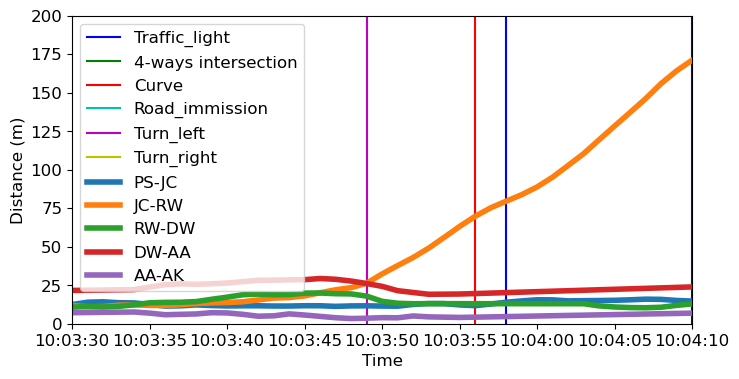

In [27]:

plt.figure(figsize = (8, 4))
plt.rcParams.update({'font.size': 12})
# plot feat
# plot feat
for i in range(len(feat)):
    first = True
    f = feat[i]
    c = list(mcolors.BASE_COLORS.values())[i]
    for t in platoon_all[platoon_all[f]]['time_']:
        if first:
            plt.axvline(t+datetime.timedelta(seconds=-7),color=c,label=f)
            first = False
        else:
             plt.axvline(t,color=c)

#keys = list(distances.keys())
keys = ['PS-JC','JC-RW','RW-DW','DW-AA','AA-AK']

                
for k in keys:
    plt.plot(distances[k]['time_'],distances[k]['dist'],label=k,linewidth=4)
xformatter = mdates.DateFormatter('%H:%M:%S')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
plt.xlabel('Time')
plt.xlim(np.datetime64('2021-03-24 10:03:30'),np.datetime64('2021-03-24 10:04:10'))
plt.ylim(0,200)
plt.ylabel('Distance (m)')
plt.legend(loc='best')
plt.savefig('images/dist-zoom.pdf',bbox_inches='tight')
plt.show()


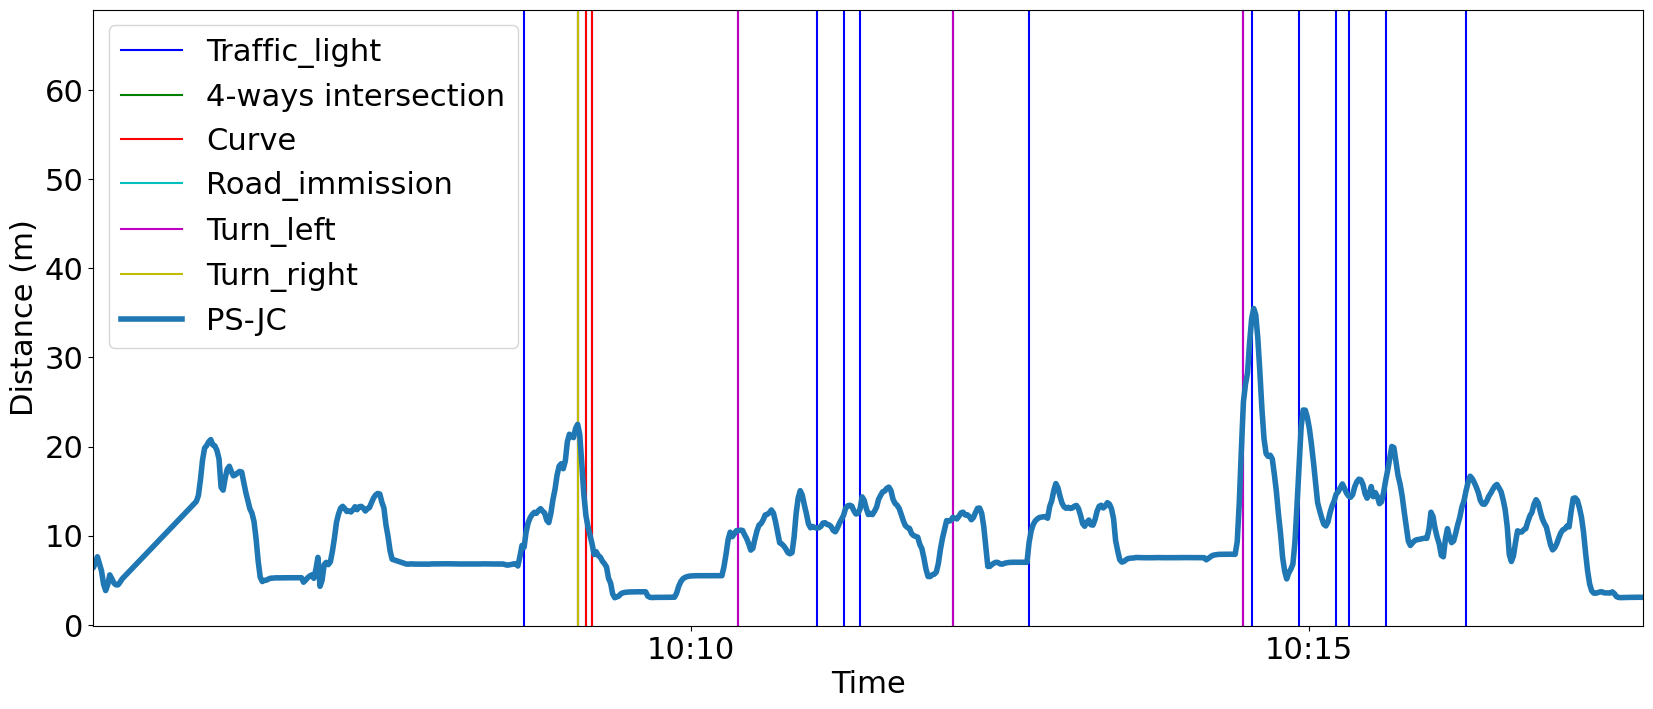

In [28]:
plt.figure(figsize = (20, 8))
plt.rcParams.update({'font.size': 22})
# plot feat
# plot feat
for i in range(len(feat)):
    first = True
    f = feat[i]
    c = list(mcolors.BASE_COLORS.values())[i]
    for t in platoon_all[platoon_all[f]]['time_']:
        if first:
            plt.axvline(t,color=c,label=f)
            first = False
        else:
             plt.axvline(t,color=c)

keys = list(distances.keys())
keys = ['PS-JC']
                
for k in keys:
    plt.plot(distances[k]['time_'],distances[k]['dist'],label=k,linewidth=4)

plt.gcf().axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel('Time')
plt.ylabel('Distance (m)')
plt.legend(loc='best')
plt.xlim(np.datetime64('2021-03-24 10:05:10'),max(distances[keys[0]]['time_']))
plt.savefig('images/dist-g1.pdf',bbox_inches='tight')
plt.show()

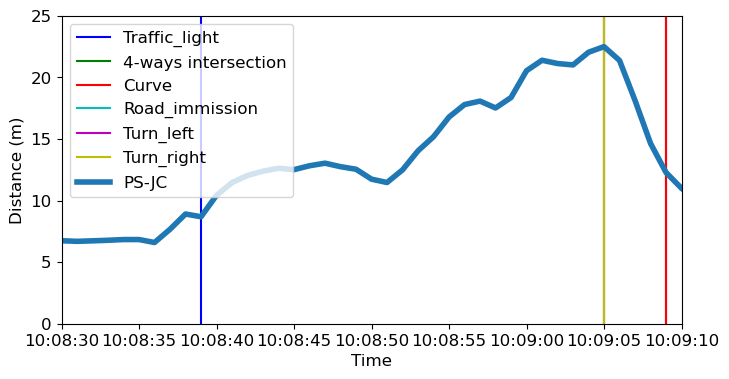

In [29]:

plt.figure(figsize = (8, 4))
plt.rcParams.update({'font.size': 12})
# plot feat
# plot feat
for i in range(len(feat)):
    first = True
    f = feat[i]
    c = list(mcolors.BASE_COLORS.values())[i]
    for t in platoon_all[platoon_all[f]]['time_']:
        if first:
            plt.axvline(t+datetime.timedelta(seconds=-7),color=c,label=f)
            first = False
        else:
             plt.axvline(t,color=c)

#keys = list(distances.keys())
keys = ['PS-JC']

                
for k in keys:
    plt.plot(distances[k]['time_'],distances[k]['dist'],label=k,linewidth=4)
xformatter = mdates.DateFormatter('%H:%M:%S')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
plt.xlabel('Time')
plt.xlim(np.datetime64('2021-03-24 10:08:30'),np.datetime64('2021-03-24 10:09:10'))
plt.ylim(0,25)
plt.ylabel('Distance (m)')
plt.legend(loc='best')
plt.savefig('images/dist-g1-zoom.pdf',bbox_inches='tight')
plt.show()


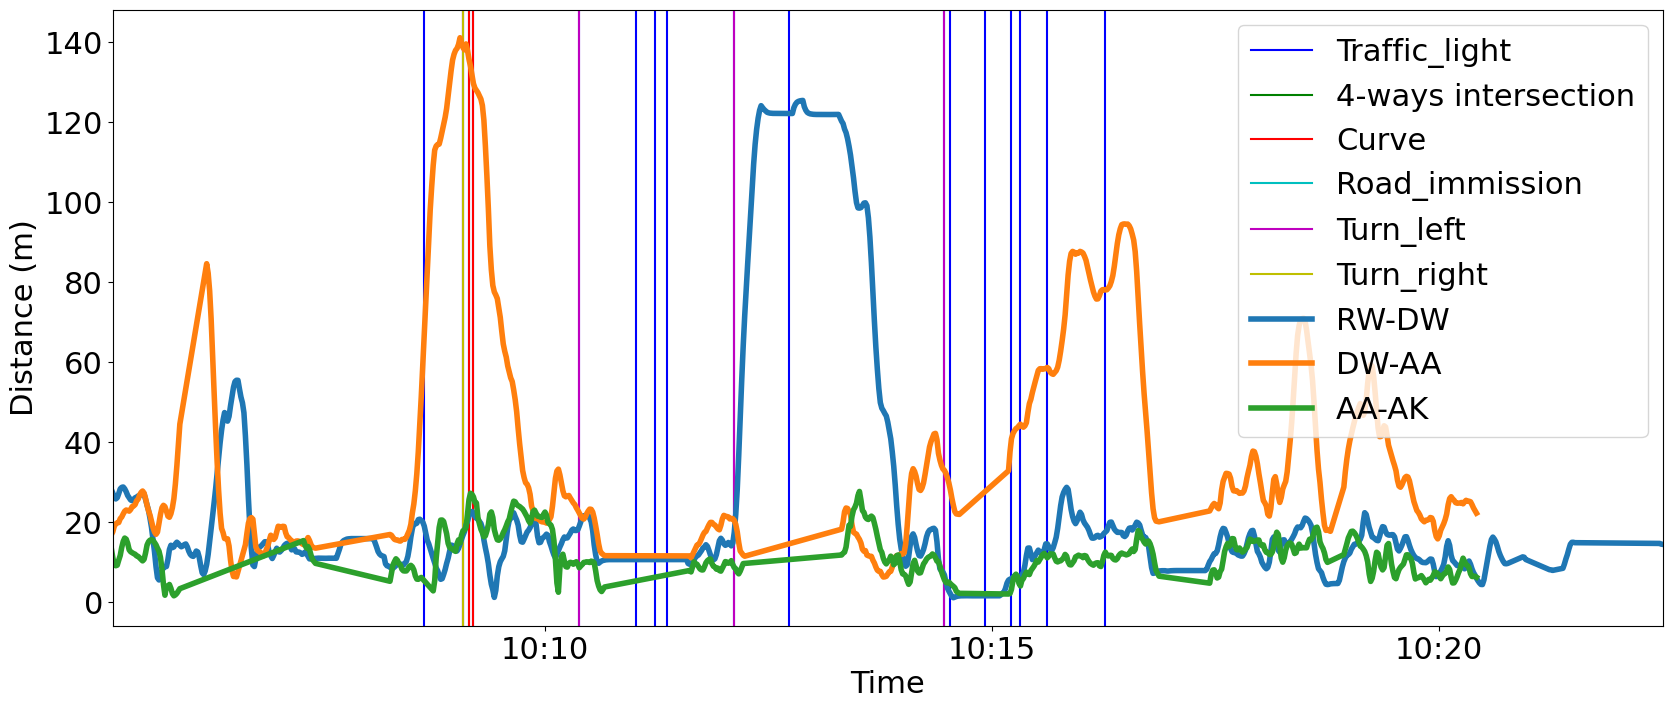

In [30]:
plt.figure(figsize = (20, 8))
plt.rcParams.update({'font.size': 22})
# plot feat
# plot feat
for i in range(len(feat)):
    first = True
    f = feat[i]
    c = list(mcolors.BASE_COLORS.values())[i]
    for t in platoon_all[platoon_all[f]]['time_']:
        if first:
            plt.axvline(t,color=c,label=f)
            first = False
        else:
             plt.axvline(t,color=c)

keys = list(distances.keys())
keys = ['RW-DW','DW-AA','AA-AK']
                
for k in keys:
    plt.plot(distances[k]['time_'],distances[k]['dist'],label=k,linewidth=4)

plt.gcf().axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel('Time')
plt.ylabel('Distance (m)')
plt.legend(loc='best')
plt.xlim(np.datetime64('2021-03-24 10:05:10'),max(distances[keys[0]]['time_']))
plt.savefig('images/dist-g2.pdf',bbox_inches='tight')
plt.show()

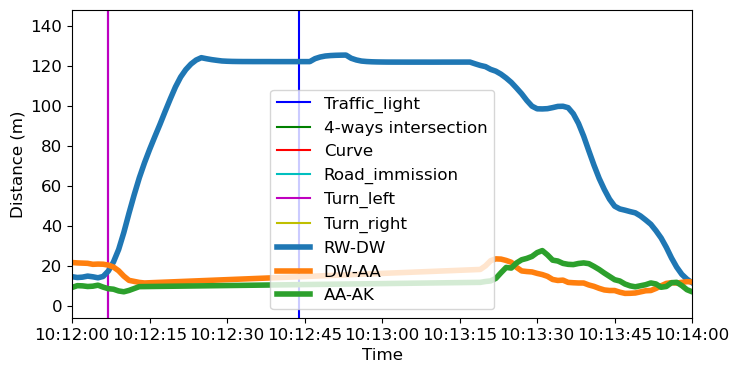

In [31]:
plt.figure(figsize = (8, 4))
plt.rcParams.update({'font.size': 12})
# plot feat
# plot feat
for i in range(len(feat)):
    first = True
    f = feat[i]
    c = list(mcolors.BASE_COLORS.values())[i]
    for t in platoon_all[platoon_all[f]]['time_']:
        if first:
            plt.axvline(t+datetime.timedelta(seconds=-7),color=c,label=f)
            first = False
        else:
             plt.axvline(t,color=c)

#keys = list(distances.keys())
keys = ['RW-DW','DW-AA','AA-AK']

                
for k in keys:
    plt.plot(distances[k]['time_'],distances[k]['dist'],label=k,linewidth=4)
xformatter = mdates.DateFormatter('%H:%M:%S')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
plt.xlabel('Time')
plt.xlim(np.datetime64('2021-03-24 10:12:00'),np.datetime64('2021-03-24 10:14:00'))
plt.ylabel('Distance (m)')
plt.legend(loc='best')
plt.savefig('images/dist-g2-zoom.pdf',bbox_inches='tight')
plt.show()

In [32]:
# REGRESSION

In [33]:
ps

,Time[s],time_,Latitude,Longtitude,Speed[m/s],Acceleration[m/s^2],CO2[kg],Fuel[l],driver,CO2[kg]_CUM,Traffic_light,4-ways intersection,Curve,Road_immission,Turn_left,Turn_right,tmp
0,1616579696,2021-03-24 09:54:56,53.555782,9.972534,1.21,NaN,NaN,NaN,PS,NaN,False,False,False,False,False,False,217.309799
1,1616579698,2021-03-24 09:54:58,53.555778,9.972510,1.53,0.160,0.000347,0.000130,PS,0.000347,False,False,False,False,False,False,216.940923
2,1616579699,2021-03-24 09:54:59,53.555774,9.972457,2.56,1.030,0.000969,0.000364,PS,0.001316,False,False,False,False,False,False,216.608796
3,1616579700,2021-03-24 09:55:00,53.555761,9.972406,3.02,0.460,0.000676,0.000254,PS,0.001992,False,False,False,False,False,False,215.364591
4,1616579702,2021-03-24 09:55:02,53.555714,9.972346,3.71,0.345,0.001343,0.000504,PS,0.003335,False,False,False,False,False,False,210.532632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,1616581058,2021-03-24 10:17:38,53.555851,9.972632,0.02,0.010,0.000112,0.000042,PS,1.083586,False,False,False,False,False,False,224.941898
1306,1616581059,2021-03-24 10:17:39,53.555851,9.972632,0.01,-0.010,0.000111,0.000042,PS,1.083697,False,False,False,False,False,False,224.941898
1307,1616581060,2021-03-24 10:17:40,53.555851,9.972632,0.01,0.000,0.000111,0.000042,PS,1.083808,False,False,False,False,False,False,224.941898
1308,1616581061,2021-03-24 10:17:41,53.555851,9.972632,0.01,0.000,0.000111,0.000042,PS,1.083920,False,False,False,False,False,False,224.941898


In [34]:
def f(row):
    return hs.haversine((row['Latitude_x'],row['Longtitude_x']),(row['Latitude_y'],row['Longtitude_y']),unit=Unit.METERS)

df = [ps,jc,rw,dw,aa,ak]
names = ['PS','JC','RW','DW','AA','AK']

distances = {}

for i in range(len(df)):
    for j in range(i+1,len(df)):
        x = df[i][['time_','Latitude','Longtitude']].merge(df[j][['time_','Latitude','Longtitude','CO2[kg]']+list(feat)],on='time_')
        x['dist'] = x.apply(f,axis='columns')
        x['old_dist'] = x['dist'].shift(10)
        distances[names[i]+'-'+names[j]] = x.dropna()

list(distances.keys())

['PS-JC',
 'PS-RW',
 'PS-DW',
 'PS-AA',
 'PS-AK',
 'JC-RW',
 'JC-DW',
 'JC-AA',
 'JC-AK',
 'RW-DW',
 'RW-AA',
 'RW-AK',
 'DW-AA',
 'DW-AK',
 'AA-AK']

In [35]:
df = pd.concat(list(distances.values()))
df

,time_,Latitude_x,Longtitude_x,Latitude_y,Longtitude_y,CO2[kg],Traffic_light,4-ways intersection,Curve,Road_immission,Turn_left,Turn_right,dist,old_dist
10,2021-03-24 09:55:24,53.555758,9.972941,53.555832,9.972799,0.000069,False,False,False,False,False,False,12.453115,10.929532
11,2021-03-24 09:55:25,53.555745,9.972962,53.555821,9.972822,0.000098,False,False,False,False,False,False,12.510102,9.810833
12,2021-03-24 09:55:26,53.555726,9.972981,53.555809,9.972846,0.001026,False,False,False,False,False,False,12.876918,7.020654
13,2021-03-24 09:55:27,53.555706,9.972996,53.555791,9.972878,0.000363,False,False,False,False,False,False,12.315264,8.467399
14,2021-03-24 09:55:28,53.555687,9.973011,53.555770,9.972910,0.000000,False,False,False,False,False,False,11.400893,10.215594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,2021-03-24 10:20:21,53.555473,9.973278,53.555412,9.973312,0.000000,False,False,False,False,False,False,7.147351,5.531536
949,2021-03-24 10:20:22,53.555515,9.973245,53.555463,9.973287,0.000000,False,False,False,False,False,False,6.457644,6.412061
950,2021-03-24 10:20:23,53.555553,9.973208,53.555505,9.973263,0.001991,False,False,False,False,False,False,6.469395,7.466392
951,2021-03-24 10:20:24,53.555588,9.973175,53.555543,9.973238,0.000000,False,False,False,False,False,False,6.516800,8.293759


In [36]:

#df = distances['LA-PS']
df.head(2)
X = df[['old_dist']+list(feat)]
X = X.replace(True, 1)
X = X.replace(False, 0)
y = df['dist']
#X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   dist   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          2.839e+05
Date:                Wed, 09 Aug 2023   Prob (F-statistic):                        0.00
Time:                        00:09:50   Log-Likelihood:                         -87122.
No. Observations:               16890   AIC:                                  1.743e+05
Df Residuals:                   16883   BIC:                                  1.743e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
old_dist                1.0049      0.001   1400.780      0.000       1.003       1.006
Traffic_light           9.1830      2.180      4.213      0.000       4.911      13.455
4-ways intersection     4.7270      6.427      0.735      0.462      -7.871      17.325
Curve                  32.9123      4.509      7.299      0.000      24.074      41.750
Road_immission          0.0635     10.864      0.006      0.995     -21.231      21.358
Turn_left              -3.4434      4.957     -0.695      0.487     -13.159       6.272
Turn_right             23.4378      6.765      3.465      0.001      10.179      36.697
==============================================================================
Omnibus:                     7636.491   Durbin-Watson:                   0.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           164823.248
Skew:                           1.667   Prob(JB):                         0.00
Kurtosis:                      17.936   Cond. No.                     1.52e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.52e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
# EXRTA PER PAPER

In [38]:
interv_dist_weights = {
    'Traffic_light':2.6767,
    'Turn_left':14.7726,
    'Turn_right':13.8288,
    'Curve':0.0,
    '4-ways intersection':6.1864,
    'distance':0.0
}

co2_weights = {
    'Traffic_light':0.0060,
    'Turn_left':0.0,
    'Turn_right':0.0088,
    'Curve':0.0049,
    '4-ways intersection':0.0088,
    'distance':0.1
}


df = jc
df['distance'] = 7.7 / df.shape[0]


def f(row,weight):
    w = 0
    for k,v in weight.items():
        w += row[k] * v
    return w

df['simCO2'] = df.apply(f,axis='columns',args=[co2_weights])
df['simIV-Distance'] = df.apply(f,axis='columns',args=[interv_dist_weights])
df['simCO2_CUM'] = df['simCO2'].expanding().sum()
df.head(2)

,Time[s],time_,Latitude,Longtitude,Speed[m/s],Acceleration[m/s^2],CO2[kg],Fuel[l],driver,CO2[kg]_CUM,...,4-ways intersection,Curve,Road_immission,Turn_left,Turn_right,tmp,distance,simCO2,simIV-Distance,simCO2_CUM
0,1616579710,2021-03-24 09:55:10,53.555826,9.972878,0.0,NaN,NaN,NaN,JC,NaN,...,False,False,False,False,False,222.669416,0.005919,0.000592,0.0,0.000592
1,1616579711,2021-03-24 09:55:11,53.555826,9.972878,0.0,0.0,0.000111,0.000042,JC,0.000111,...,False,False,False,False,False,222.669416,0.005919,0.000592,0.0,0.001184


In [39]:
df.columns

Index(['Time[s]', 'time_', 'Latitude', 'Longtitude', 'Speed[m/s]',
       'Acceleration[m/s^2]', 'CO2[kg]', 'Fuel[l]', 'driver', 'CO2[kg]_CUM',
       'Traffic_light', '4-ways intersection', 'Curve', 'Road_immission',
       'Turn_left', 'Turn_right', 'tmp', 'distance', 'simCO2',
       'simIV-Distance', 'simCO2_CUM'],
      dtype='object')

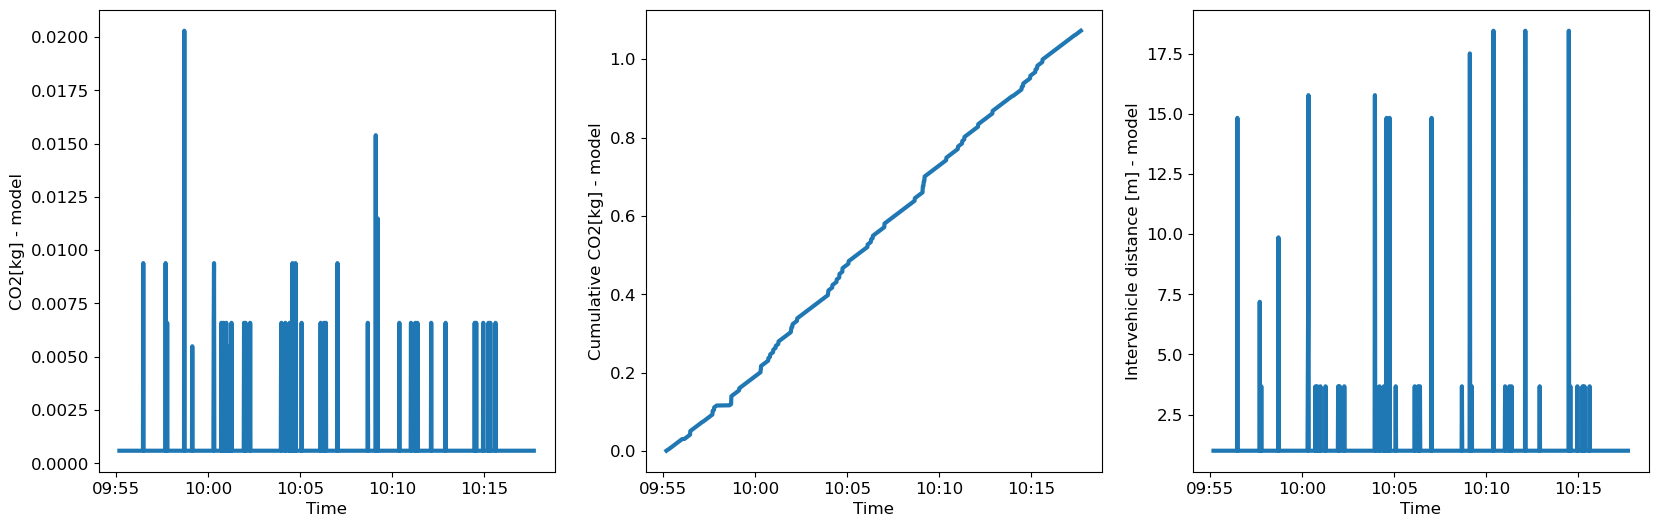

In [40]:
plt.figure(figsize = (20, 6))
plt.rcParams.update({'font.size': 12})

plt.subplot(1, 3, 1)
plt.plot(df['time_'],df['simCO2'],linewidth=3)
plt.gcf().axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel('Time')
plt.ylabel('CO2[kg] - model')

plt.subplot(1, 3, 2)
plt.plot(df['time_'],df['simCO2_CUM'],linewidth=3)
plt.gcf().axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel('Time')
plt.ylabel('Cumulative CO2[kg] - model')

plt.subplot(1, 3, 3)
plt.plot(df['time_'],df['simIV-Distance']+1,linewidth=3)
plt.gcf().axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel('Time')
plt.ylabel('Intervehicle distance [m] - model')


plt.savefig('images/sim_results.pdf',bbox_inches='tight')  
plt.show()